In [1]:
import os
import glob
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.bag as db

import matplotlib.pyplot as plt
import seaborn as sns


/om2/user/jsmentch/anaconda/envs/hbn/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [25]:
# use hbn conda env

In [2]:
def get_imaging_site(identifier):
    path = f'/nese/mit/group/sig/projects/hbn/hbn_bids/sub-{identifier}/'
    if os.path.isdir(path + 'ses-HBNsiteRU'):
        return 'RU'
    elif os.path.isdir(path + 'ses-HBNsiteCBIC'):
        return 'CBIC'
    elif os.path.isdir(path + 'ses-HBNsiteSI'):
        return 'SI'
    elif os.path.isdir(path + 'ses-HBNsiteCUNY'):
        return 'CUNY'
    else:
        return None

In [3]:
dx_final=pd.read_csv('/nese/mit/group/sig/projects/naturalistic/nat_img/sourcedata/data/HBN/phenotype/parsed/dx_onehot.csv')
dx_final['imaging_site'] = dx_final['Identifiers'].apply(get_imaging_site)
#asd_df = dx_final[dx_final['Autism Spectrum Disorder'] == 1][['Identifiers']]
filtered_df = dx_final[dx_final['Autism Spectrum Disorder'] == 1]
asd_df = filtered_df[['Identifiers','imaging_site']].rename(columns={'Identifiers': 'subj_id'})
asd_df['subj_id'] = 'sub-' + asd_df['subj_id'].astype(str)
#nt_df = dx_final[dx_final['No Diagnosis Given'] == 1][['Identifiers']]
filtered_df = dx_final[dx_final['No Diagnosis Given'] == 1]
nt_df = filtered_df[['Identifiers','imaging_site']].rename(columns={'Identifiers': 'subj_id'})
nt_df['subj_id'] = 'sub-' + nt_df['subj_id'].astype(str)

## compare to Yibei's controls:

In [7]:
# for i in [9,8,7]:
#     yibei_nt=pd.read_csv(f'../../hbn_adhd/code/control_subs_test{i}.csv')
#     #yibei_nt['subj_id'] = 'sub-' + yibei_nt['subj_id'].astype(str)
#     nt_test=yibei_nt.merge(dx_final, on="Identifiers", how='inner')
#     df_selected = nt_test.iloc[:, 4:]
#     nt_test_sum = df_selected.sum()
#     nt_test_sum = nt_test_sum[nt_test_sum != 0]
#     print(f'\n~+~+~+~+~+~+~+~+~+~THRESHOLD={i}')
#     print(nt_test_sum.to_string())

## load qc data and save as csvs

In [9]:
#load_dotenv()

base_dir = os.getenv("BASE_DIR")
base_dir='/nese/mit/group/sig/projects/hbn/'
#project_dir = os.getenv("PROJECT_DIR")
project_dir='/nese/mit/group/sig/projects/hbn/'
data_dir = os.path.join(project_dir, "hbn_bids", "derivatives")
#output_dir = os.path.join(base_dir, "fmri", "output")
#save_dir = os.path.join(output_dir, "qc")
#os.makedirs(save_dir, exist_ok=True)

In [10]:
def json2csv(files):
    """
    Reads a list of JSON files, transposes each file, and concatenates the results into a single DataFrame.

    Parameters:
    - files (list of str): List of paths to the JSON files.

    Returns:
    - pd.DataFrame: A concatenated DataFrame of the transposed JSON files.
    """
    dfs = []

    for file in files:
        # Read with pandas, transpose, and convert to Dask DataFrame
        subj_id = file.split("/")[-1].split("_")[0]
        task = file.split("/")[-1].split("_")[-2]
        df = pd.read_json(file, orient='index').T
        df["subj_id"] = subj_id
        df["task"] = task
        dask_df = dd.from_pandas(df, npartitions=1)
        dfs.append(dask_df)

    # Concatenate all the Dask DataFrames
    concat_df = dd.concat(dfs).compute()
    return concat_df

In [8]:
movieDM_qc_files = glob.glob(os.path.join(data_dir, "mriqc_23.1.0", "sub-*",  "*", "func", "*task-movieDM*.json"))
movieDM_qc_files.sort()
movieTP_qc_files = glob.glob(os.path.join(data_dir, "mriqc_23.1.0", "sub-*",  "*", "func", "*task-movieTP*.json"))
movieTP_qc_files.sort()
rest1_qc_files = glob.glob(os.path.join(data_dir, "mriqc_23.1.0", "sub-*",  "*", "func", "*task-rest_run-1*.json"))
rest1_qc_files.sort()
rest2_qc_files = glob.glob(os.path.join(data_dir, "mriqc_23.1.0", "sub-*",  "*", "func", "*task-rest_run-2*.json"))
rest2_qc_files.sort()

NameError: name 'data_dir' is not defined

In [7]:
movieDM_qc = json2csv(movieDM_qc_files)
movieTP_qc = json2csv(movieTP_qc_files)
rest1_qc = json2csv(rest1_qc_files)
rest2_qc = json2csv(rest2_qc_files)

In [24]:
iqms = ['subj_id',"aor", "aqi", 'dvars_nstd', 'dvars_std', 'dvars_vstd', 'efc', 
        'fber', 'fd_mean', 'fd_num', 'fd_perc', 'fwhm_avg', 'gcor', 
        'gsr_x', 'gsr_y', 'snr', 'spacing_tr', 'tsnr']

In [10]:
movieDM_qc.to_csv(os.path.join("movieDM_qc.csv"), index=False)
movieTP_qc.to_csv(os.path.join("movieTP_qc.csv"), index=False)
rest1_qc.to_csv(os.path.join(  "rest1_qc.csv"  ), index=False)
rest2_qc.to_csv(os.path.join(  "rest2_qc.csv"  ), index=False)

## load saved qc csvs

In [5]:
movieDM_qc = pd.read_csv("../sourcedata/data/HBN/phenotype/movieDM_qc.csv")
movieTP_qc = pd.read_csv("../sourcedata/data/HBN/phenotype/movieTP_qc.csv")
rest1_qc = pd.read_csv(  "../sourcedata/data/HBN/phenotype/rest1_qc.csv"  )
rest2_qc = pd.read_csv(  "../sourcedata/data/HBN/phenotype/rest2_qc.csv"  )

In [6]:
def convert_to_float(df):
    df = df.apply(lambda col: col.astype(float) if col.name != 'subj_id' else col)
    return df

iqms = ['subj_id',"aor", "aqi", 'dvars_nstd', 'dvars_std', 'dvars_vstd', 'efc', 
        'fber', 'fd_mean', 'fd_num', 'fd_perc', 'fwhm_avg', 'gcor', 
        'gsr_x', 'gsr_y', 'snr', 'spacing_tr', 'tsnr']

dm_qc = convert_to_float(  movieDM_qc[iqms] )
tp_qc = convert_to_float(  movieTP_qc[iqms] )
r1_qc = convert_to_float(  rest1_qc[iqms] )
r2_qc = convert_to_float(  rest2_qc[iqms] )

In [7]:
def count_subjects(dm_qc,tp_qc,r1_qc,r2_qc):
    dm_qc_subj_id = dm_qc[['subj_id']]
    tp_qc_subj_id = tp_qc[['subj_id']]
    r1_qc_subj_id = r1_qc[['subj_id']]
    r2_qc_subj_id = r2_qc[['subj_id']]
    
    ###### See how many subjects (union)
    combined_df = pd.concat([dm_qc_subj_id, tp_qc_subj_id, r1_qc_subj_id, r2_qc_subj_id])
    subjs_anyruns = combined_df.drop_duplicates()

    asd_any_runs=subjs_anyruns.merge(asd_df, on="subj_id", how='inner')
    nt_any_runs=subjs_anyruns.merge(nt_df, on="subj_id", how='inner')

    print(f"{len(subjs_anyruns)} w/ any fmriprepped data ({len(asd_any_runs)} ASD, {len(nt_any_runs)} NT)")
    
    values = ['RU','CUNY','CBIC','SI']
    filtered_df = asd_any_runs[asd_any_runs['imaging_site'].isin(values)]
    counts_asd = filtered_df['imaging_site'].value_counts()
    filtered_df = nt_any_runs[nt_any_runs['imaging_site'].isin(values)]
    counts_nt = filtered_df['imaging_site'].value_counts()
    for v in values:
        #print(f"v= {v},{counts_asd} ")
        try:
            print(f"----Site {v}: {counts_asd[v]} ASD, {counts_nt[v]} NT")
        except:
            print(f"----Site {v}: a group has 0")
            #pass
    print(f"----Site RU+CBIC: {counts_asd['RU']+counts_asd['CBIC']} ASD, {counts_nt['RU']+counts_nt['CBIC']} NT")
    
    ####### see how many have all 4 runs
    subjs_allruns = dm_qc_subj_id.merge(tp_qc_subj_id, on="subj_id", how='inner').merge(r1_qc_subj_id, on="subj_id", how='inner').merge(r2_qc_subj_id, on="subj_id", how='inner')
    num_common_rows = len(subjs_allruns)

    asd_all_runs=subjs_allruns.merge(asd_df, on="subj_id", how='inner')
    nt_all_runs=subjs_allruns.merge(nt_df, on="subj_id", how='inner')

    print(f"{num_common_rows} w/ all 4 runs ({len(asd_all_runs)} ASD, {len(nt_all_runs)} NT )")


    values = ['RU','CUNY','CBIC','SI']
    filtered_df = asd_all_runs[asd_all_runs['imaging_site'].isin(values)]
    counts_asd = filtered_df['imaging_site'].value_counts()
    filtered_df = nt_all_runs[nt_all_runs['imaging_site'].isin(values)]
    counts_nt = filtered_df['imaging_site'].value_counts()
    
    for v in values:
        try: print(f"----Site {v}: {counts_asd[v]} ASD, {counts_nt[v]} NT")
        except:
            print(f"----Site {v}: a group has 0")
            #pass
    print(f"----Site RU+CBIC: {counts_asd['RU']+counts_asd['CBIC']} ASD, {counts_nt['RU']+counts_nt['CBIC']} NT")

    ###### see how many have at least despicable me
    target_df = dm_qc_subj_id

    num_common_rows = len(target_df)
    
    asd_target_df=target_df.merge(asd_df, on="subj_id", how='inner')
    nt_target_df=target_df.merge(nt_df, on="subj_id", how='inner')

    values = ['RU','CUNY','CBIC','SI']
    filtered_df1 = asd_target_df[asd_target_df['imaging_site'].isin(values)]
    counts_asd = filtered_df1['imaging_site'].value_counts()
    filtered_df2 = nt_target_df[nt_target_df['imaging_site'].isin(values)]
    counts_nt = filtered_df2['imaging_site'].value_counts()
    
    print(f"{num_common_rows} w/ at least DM ({len(asd_target_df)} ASD, {len(nt_target_df)} NT )")
    for v in values:
        try: print(f"----Site {v}: {counts_asd[v]} ASD, {counts_nt[v]} NT")
        except:
            print(f"----Site {v}: a group has 0")
            #pass
    print(f"----Site RU+CBIC: {counts_asd['RU']+counts_asd['CBIC']} ASD, {counts_nt['RU']+counts_nt['CBIC']} NT")
    

    ###### see how many have at least one resting state and DM
    target_df = pd.merge(dm_qc_subj_id, r1_qc_subj_id, on="subj_id", how="inner")
    target_df2 = pd.merge(dm_qc_subj_id, r2_qc_subj_id, on="subj_id", how="inner")
    
    target_df = pd.merge(target_df, target_df2, on="subj_id", how="outer")
    num_common_rows = len(target_df)
    
    asd_target_df=target_df.merge(asd_df, on="subj_id", how='inner')
    nt_target_df=target_df.merge(nt_df, on="subj_id", how='inner')

    values = ['RU','CUNY','CBIC','SI']
    filtered_df = asd_target_df[asd_target_df['imaging_site'].isin(values)]
    counts_asd = filtered_df['imaging_site'].value_counts()
    filtered_df = nt_target_df[nt_target_df['imaging_site'].isin(values)]
    counts_nt = filtered_df['imaging_site'].value_counts()
    
    print(f"{num_common_rows} w/ at least DM and 1 resting state ({len(asd_target_df)} ASD, {len(nt_target_df)} NT )")
    print(f"----Site RU+CBIC: {counts_asd['RU']+counts_asd['CBIC']} ASD, {counts_nt['RU']+counts_nt['CBIC']} NT")

    ###### see how many have at least both resting state and DM
    target_df = dm_qc_subj_id.merge(r1_qc_subj_id, on="subj_id", how='inner').merge(r2_qc_subj_id, on="subj_id", how='inner')

    num_common_rows = len(target_df)
    
    asd_target_df=target_df.merge(asd_df, on="subj_id", how='inner')
    nt_target_df=target_df.merge(nt_df, on="subj_id", how='inner')

    values = ['RU','CUNY','CBIC','SI']
    filtered_df_asd = asd_target_df[asd_target_df['imaging_site'].isin(values)]
    counts_asd = filtered_df_asd['imaging_site'].value_counts()
    filtered_df_nt = nt_target_df[nt_target_df['imaging_site'].isin(values)]
    counts_nt = filtered_df_nt['imaging_site'].value_counts()
    
    print(f"{num_common_rows} w/ at least DM and both resting state ({len(asd_target_df)} ASD, {len(nt_target_df)} NT )")
    print(f"----Site RU+CBIC: {counts_asd['RU']+counts_asd['CBIC']} ASD, {counts_nt['RU']+counts_nt['CBIC']} NT")

    
    return subjs_anyruns,subjs_allruns, filtered_df1,filtered_df2


anyruns,allruns,filtered_df_asd,filtered_df_nt=count_subjects(dm_qc,tp_qc,r1_qc,r2_qc)

2618 w/ any fmriprepped data (333 ASD, 178 NT)
----Site RU: 139 ASD, 106 NT
----Site CUNY: 31 ASD, 15 NT
----Site CBIC: 163 ASD, 57 NT
----Site SI: a group has 0
----Site RU+CBIC: 302 ASD, 163 NT
1734 w/ all 4 runs (213 ASD, 103 NT )
----Site RU: 84 ASD, 61 NT
----Site CUNY: 26 ASD, 9 NT
----Site CBIC: 103 ASD, 33 NT
----Site SI: a group has 0
----Site RU+CBIC: 187 ASD, 94 NT
2274 w/ at least DM (288 ASD, 162 NT )
----Site RU: 119 ASD, 101 NT
----Site CUNY: 29 ASD, 14 NT
----Site CBIC: 140 ASD, 47 NT
----Site SI: a group has 0
----Site RU+CBIC: 259 ASD, 148 NT
1883 w/ at least DM and 1 resting state (232 ASD, 108 NT )
----Site RU+CBIC: 203 ASD, 99 NT
1785 w/ at least DM and both resting state (223 ASD, 106 NT )
----Site RU+CBIC: 196 ASD, 97 NT


## filter out based on Yibei

In [9]:
def yibei_filter(df_in):
    dm_mean_fd_perc = df_in['fd_perc'].mean()
    dm1 = df_in[df_in['fd_perc'] < dm_mean_fd_perc]
    
    dm_mean_tsnr = df_in['tsnr'].mean()
    dm2 = dm1[dm1['tsnr'] > dm_mean_tsnr]
    return dm2

dm_qc_yibei=yibei_filter(dm_qc)
tp_qc_yibei=yibei_filter(tp_qc)
r1_qc_yibei=yibei_filter(r1_qc)
r2_qc_yibei=yibei_filter(r2_qc)

anyruns,allruns,filtered_df_asd,filtered_df_nt=count_subjects(dm_qc_yibei,tp_qc_yibei,r1_qc_yibei,r2_qc_yibei)

1389 w/ any fmriprepped data (170 ASD, 107 NT)
----Site RU: 77 ASD, 66 NT
----Site CUNY: 16 ASD, 5 NT
----Site CBIC: 77 ASD, 36 NT
----Site SI: a group has 0
----Site RU+CBIC: 154 ASD, 102 NT
378 w/ all 4 runs (39 ASD, 29 NT )
----Site RU: 18 ASD, 22 NT
----Site CUNY: 5 ASD, 1 NT
----Site CBIC: 16 ASD, 6 NT
----Site SI: a group has 0
----Site RU+CBIC: 34 ASD, 28 NT
837 w/ at least DM (99 ASD, 66 NT )
----Site RU: 43 ASD, 47 NT
----Site CUNY: 10 ASD, 3 NT
----Site CBIC: 46 ASD, 16 NT
----Site SI: a group has 0
----Site RU+CBIC: 89 ASD, 63 NT
617 w/ at least DM and 1 resting state (72 ASD, 42 NT )
----Site RU+CBIC: 63 ASD, 41 NT
509 w/ at least DM and both resting state (57 ASD, 34 NT )
----Site RU+CBIC: 50 ASD, 33 NT


## filter out based on dorit

In [10]:
def dorit_filter(df_in):
    #If the number of timepoints with a mean FD > 0.2mm is greater than 40% per individual the subject will be excluded 
    dm1 = df_in[df_in['fd_perc'] < 40]
    
    # dm_mean_tsnr = df_in['tsnr'].mean()
    # dm2 = dm1[dm1['tsnr'] > dm_mean_tsnr]
    return dm1

dm_qc_dorit=dorit_filter(dm_qc)
tp_qc_dorit=dorit_filter(tp_qc)
r1_qc_dorit=dorit_filter(r1_qc)
r2_qc_dorit=dorit_filter(r2_qc)

anyruns,allruns,filtered_df_asd,filtered_df_nt=count_subjects(dm_qc_dorit,
                               tp_qc_dorit,
                               r1_qc_dorit,
                               r2_qc_dorit)

1416 w/ any fmriprepped data (173 ASD, 100 NT)
----Site RU: 69 ASD, 59 NT
----Site CUNY: 17 ASD, 4 NT
----Site CBIC: 87 ASD, 37 NT
----Site SI: a group has 0
----Site RU+CBIC: 156 ASD, 96 NT
453 w/ all 4 runs (56 ASD, 32 NT )
----Site RU: 25 ASD, 20 NT
----Site CUNY: 6 ASD, 1 NT
----Site CBIC: 25 ASD, 11 NT
----Site SI: a group has 0
----Site RU+CBIC: 50 ASD, 31 NT
871 w/ at least DM (106 ASD, 67 NT )
----Site RU: 40 ASD, 42 NT
----Site CUNY: 10 ASD, 1 NT
----Site CBIC: 56 ASD, 24 NT
----Site SI: a group has 0
----Site RU+CBIC: 96 ASD, 66 NT
649 w/ at least DM and 1 resting state (72 ASD, 42 NT )
----Site RU+CBIC: 63 ASD, 41 NT
528 w/ at least DM and both resting state (63 ASD, 37 NT )
----Site RU+CBIC: 54 ASD, 36 NT


## filter out based on only yibei FD filter

In [11]:
def yibei_lax_filter(df_in):
    dm_mean_fd_perc = df_in['fd_perc'].mean()
    dm2 = df_in[df_in['fd_perc'] < dm_mean_fd_perc]
    
    # dm_mean_tsnr = df_in['tsnr'].mean()
    # dm2 = dm1[dm1['tsnr'] > dm_mean_tsnr]
    return dm2

dm_qc_yibei=yibei_lax_filter(dm_qc)
tp_qc_yibei=yibei_lax_filter(tp_qc)
r1_qc_yibei=yibei_lax_filter(r1_qc)
r2_qc_yibei=yibei_lax_filter(r2_qc)

anyruns,allruns,filtered_df_asd,filtered_df_nt=count_subjects(dm_qc_yibei,tp_qc_yibei,r1_qc_yibei,r2_qc_yibei)

1621 w/ any fmriprepped data (194 ASD, 120 NT)
----Site RU: 79 ASD, 72 NT
----Site CUNY: 18 ASD, 5 NT
----Site CBIC: 97 ASD, 43 NT
----Site SI: a group has 0
----Site RU+CBIC: 176 ASD, 115 NT
584 w/ all 4 runs (67 ASD, 39 NT )
----Site RU: 26 ASD, 25 NT
----Site CUNY: 7 ASD, 1 NT
----Site CBIC: 34 ASD, 13 NT
----Site SI: a group has 0
----Site RU+CBIC: 60 ASD, 38 NT
1100 w/ at least DM (131 ASD, 85 NT )
----Site RU: 48 ASD, 54 NT
----Site CUNY: 13 ASD, 3 NT
----Site CBIC: 70 ASD, 28 NT
----Site SI: a group has 0
----Site RU+CBIC: 118 ASD, 82 NT
819 w/ at least DM and 1 resting state (96 ASD, 51 NT )
----Site RU+CBIC: 84 ASD, 50 NT
696 w/ at least DM and both resting state (79 ASD, 44 NT )
----Site RU+CBIC: 69 ASD, 43 NT


## more relaxed filtering

In [12]:
def relaxed_filter(df_in):
    #If the number of timepoints with a mean FD > 0.2mm is greater than 40% per individual the subject will be excluded 
    dm1 = df_in[df_in['fd_perc'] < 50]
    
    # dm_mean_tsnr = df_in['tsnr'].mean()
    # dm2 = dm1[dm1['tsnr'] > dm_mean_tsnr]
    return dm1

dm_qc_relaxed=relaxed_filter(dm_qc)
tp_qc_relaxed=relaxed_filter(tp_qc)
r1_qc_relaxed=relaxed_filter(r1_qc)
r2_qc_relaxed=relaxed_filter(r2_qc)

anyruns,allruns,filtered_df_asd,filtered_df_nt=count_subjects(dm_qc_relaxed,
                               tp_qc_relaxed,
                               r1_qc_relaxed,
                               r2_qc_relaxed)

1717 w/ any fmriprepped data (209 ASD, 127 NT)
----Site RU: 86 ASD, 76 NT
----Site CUNY: 20 ASD, 7 NT
----Site CBIC: 103 ASD, 44 NT
----Site SI: a group has 0
----Site RU+CBIC: 189 ASD, 120 NT
646 w/ all 4 runs (75 ASD, 42 NT )
----Site RU: 28 ASD, 26 NT
----Site CUNY: 9 ASD, 1 NT
----Site CBIC: 38 ASD, 15 NT
----Site SI: a group has 0
----Site RU+CBIC: 66 ASD, 41 NT
1160 w/ at least DM (141 ASD, 90 NT )
----Site RU: 50 ASD, 55 NT
----Site CUNY: 15 ASD, 5 NT
----Site CBIC: 76 ASD, 30 NT
----Site SI: a group has 0
----Site RU+CBIC: 126 ASD, 85 NT
876 w/ at least DM and 1 resting state (103 ASD, 53 NT )
----Site RU+CBIC: 89 ASD, 52 NT
739 w/ at least DM and both resting state (84 ASD, 46 NT )
----Site RU+CBIC: 72 ASD, 45 NT


In [13]:
filtered_df_asd['subj_id'] = filtered_df_asd['subj_id'].str.replace('sub-', '')
filtered_df_nt['subj_id'] = filtered_df_nt['subj_id'].str.replace('sub-', '')

In [14]:
filter_df = pd.concat([filtered_df_asd, filtered_df_nt], ignore_index=True)
filter_df

,subj_id,imaging_site
0,NDARAD615WLJ,CBIC
1,NDARAE877NER,CBIC
2,NDARAH503YG1,RU
3,NDARAM357BUA,CUNY
4,NDARAP457WB5,CBIC
...,...,...
226,NDARZM839GHH,CUNY
227,NDARZM903TNL,CBIC
228,NDARZV421TCZ,CBIC
229,NDARZV983XK9,RU


In [15]:
#QUESTIONS

# are they matched for age?
# what is the distribution of age?

In [16]:
result = dx_final[dx_final['Identifiers'].isin(filter_df['subj_id'])]
result


,Identifiers,Age,Sex,Site,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,...,Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Feeding or Eating Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder,imaging_site
17,NDARAB653ZXP,12.009924,male,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
38,NDARAD615WLJ,6.304243,male,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
53,NDARAE877NER,11.341318,female,3,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
71,NDARAH503YG1,7.013347,male,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RU
91,NDARAL828WXM,15.188569,male,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,NDARLE554GYT,16.784280,female,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RU
4471,NDARPA917PE9,13.871206,male,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
4482,NDARPH176EWC,9.986652,male,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
4577,NDARUC771VM5,14.255076,male,3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC


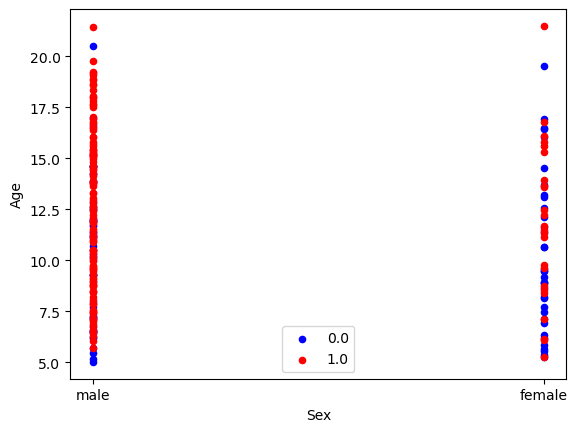

In [17]:
colors = {0: 'blue', 1: 'red'}

# plot the data
fig, ax = plt.subplots()
for key, group in result.groupby('Autism Spectrum Disorder'):
    group.plot(ax=ax, kind='scatter', x='Sex', y='Age', color=colors[key], label=key)

plt.show()

In [26]:
result

,Identifiers,Age,Sex,Site,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,...,Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Feeding or Eating Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder,imaging_site
17,NDARAB653ZXP,12.009924,male,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
38,NDARAD615WLJ,6.304243,male,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
53,NDARAE877NER,11.341318,female,3,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
71,NDARAH503YG1,7.013347,male,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RU
91,NDARAL828WXM,15.188569,male,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,NDARLE554GYT,16.784280,female,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RU
4471,NDARPA917PE9,13.871206,male,4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
4482,NDARPH176EWC,9.986652,male,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC
4577,NDARUC771VM5,14.255076,male,3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBIC


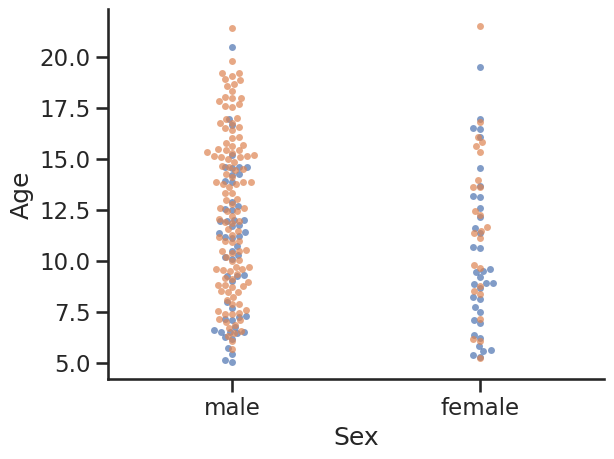

In [31]:
import seaborn as sns

sns.set(style='ticks', context='talk')


for key, group in result.groupby('Autism Spectrum Disorder'):
    #group.plot(ax=ax, kind='scatter', x='Sex', y='Age', color=colors[key], label=key)
    sns.swarmplot(data=group, x='Sex', y='Age', alpha=0.7)
sns.despine()

Text(0.5, 1.0, 'Age by diagnosis, all sites')

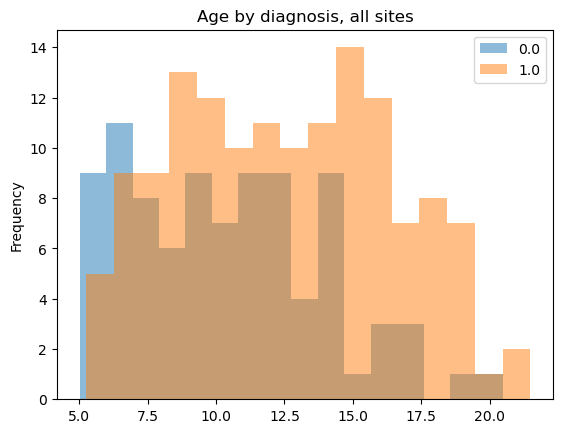

In [24]:
fig, ax = plt.subplots()
result.groupby('Autism Spectrum Disorder')['Age'].plot(kind='hist', bins=16, ax=ax,alpha=0.5,legend=True)

plt.title('Age by diagnosis, all sites')

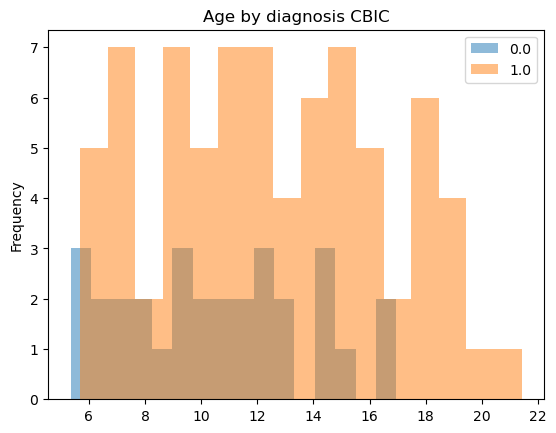

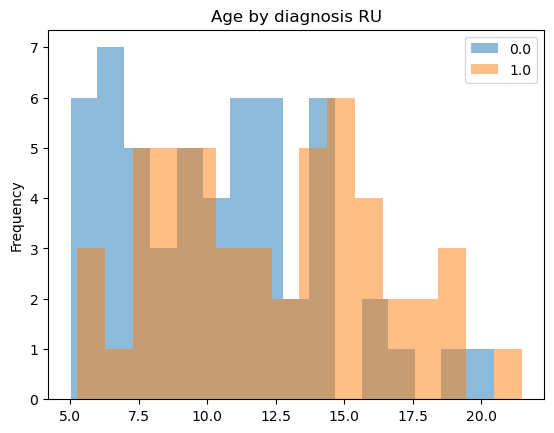

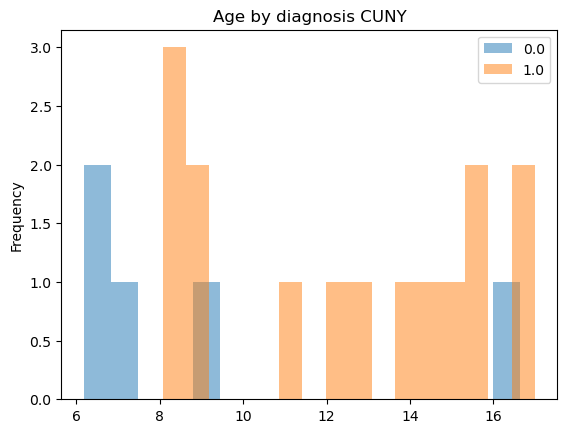

In [22]:
for site in ['CBIC', 'RU', 'CUNY']:
    
    
    fig, ax = plt.subplots()
    result[result['imaging_site'] == site].groupby('Autism Spectrum Disorder')['Age'].plot(kind='hist', bins=16, ax=ax,alpha=0.5,legend=True)
    plt.title(f'Age by diagnosis {site}')

In [106]:
#try to do age matching:


#result[result['imaging_site'] == site]



# Load the data into a pandas dataframe
df = result[['Identifiers', 'Age', 'Sex', 'Autism Spectrum Disorder','imaging_site']]

df = df.loc[(df['imaging_site'] == 'RU') | (df['imaging_site'] == 'CBIC')]


# Separate cases and controls based on the `Group` variable
cases = df[df['Autism Spectrum Disorder'] == 1]
controls = df[df['Autism Spectrum Disorder'] == 0]

# Rename the variables for cases and controls to distinguish them
cases = cases.rename(columns={'Age': 'Age_case'})
controls = controls.rename(columns={'Age': 'Age_control'})

# Join the cases and controls based on age and sex
matched = pd.merge(cases, controls, on=['Sex'])
matched = matched[(matched['Age_control'] - 1 <= matched['Age_case']) & (matched['Age_case'] <= matched['Age_control'] + 1)]

# Randomly select one match if there are more
matched = matched.sample(frac=1).groupby('Identifiers_x').head(1)
matched = matched.sample(frac=1).groupby('Identifiers_y').head(1)

# Compare the outcome variables between the case and control groups using appropriate statistical tests


In [107]:
len(matched)

33

### dm_qc.describe()

In [13]:
print(f"Mean FD: {dm_qc['fd_mean'].mean():.3f} mm\n")
print(f"Mean TSNR: {dm_qc['tsnr'].mean():.3f}\n")
print(f"Mean SNR: {dm_qc['snr'].mean():.3f}\n")
print(f"Mean DVARS: {dm_qc['dvars_std'].mean():.3f}\n")
print(f"Mean GCOR: {dm_qc['gcor'].mean():.3f}\n")


Mean FD: 0.520 mm

Mean TSNR: 27.542

Mean SNR: 2.810

Mean DVARS: 1.049

Mean GCOR: 0.030



## Framewise Displacement

### filer out fd_perc > fd_perc.mean (group mean)

`fd_perc`: the percent of FDs above the FD threshold (0.2) w.r.t. the full timeseries

In [22]:
dm_qc['fd_perc'].mean()

48.143411626439025

In [53]:
dm_mean_fd_perc = dm_qc['fd_perc'].mean()
dm1 = dm_qc[dm_qc['fd_perc'] < dm_mean_fd_perc]
print(f"{dm1.shape[0]} subjects have FD (0.2) percentage < {dm_mean_fd_perc:.2f} %")

1100 subjects have FD (0.2) percentage < 48.14 %


In [57]:
dm1.describe()

,aor,aqi,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,fd_perc,fwhm_avg,gcor,gsr_x,gsr_y,snr,spacing_tr,tsnr
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000
mean,0.002380,0.012340,38.235329,1.048682,0.995655,0.519457,1128.952728,0.211388,191.556364,25.743552,2.727841,0.022130,-0.007437,0.054006,2.781134,0.8,31.983472
std,0.003372,0.008411,13.312118,0.058479,0.088439,0.029472,459.126789,0.124288,105.733159,14.045017,0.246584,0.023694,0.009149,0.021066,0.448340,0.0,6.494614
min,0.000138,0.001913,24.727956,0.853514,0.873382,0.427141,1.230067,0.053045,0.000000,0.000000,2.220265,0.000190,-0.043818,0.009750,0.667309,0.8,7.901852
25%,0.000737,0.007696,33.929247,1.014497,0.973798,0.500520,802.881653,0.142627,101.000000,13.713655,2.571328,0.008441,-0.013414,0.039669,2.464801,0.8,27.842448
50%,0.001427,0.010844,37.263861,1.044189,0.992736,0.517894,1031.800781,0.180028,198.500000,26.835781,2.693636,0.015014,-0.008757,0.050212,2.744420,0.8,31.775132
75%,0.002676,0.014387,40.997258,1.076858,1.007397,0.537296,1443.624512,0.238163,286.000000,38.197008,2.826035,0.029655,-0.002803,0.065044,3.055000,0.8,36.381478
max,0.042380,0.170208,434.711937,1.503427,3.634369,0.763758,2501.226807,1.456239,361.000000,48.133333,4.930612,0.356133,0.033189,0.276755,4.166971,0.8,67.465315


In [64]:
print("After the first round of FD (0.2) percentage filtering:\n")
print(f"Mean FD: {dm1['fd_mean'].mean():.3f} mm\n")
print(f"Mean TSNR: {dm1['tsnr'].mean():.3f}\n")
print(f"Mean SNR: {dm1['snr'].mean():.3f}\n")
print(f"Mean DVARS: {dm1['dvars_std'].mean():.3f}\n")
print(f"Mean GCOR: {dm1['gcor'].mean():.3f}\n")

After the first round of FD (0.2) percentage filtering:

Mean FD: 0.211 mm

Mean TSNR: 31.983

Mean SNR: 2.781

Mean DVARS: 1.049

Mean GCOR: 0.022



## Filter out low temporal SNR

We notice that the minimal value of `tsnr` in `dm1` is 7.901852, which is too low

We are going to use the group (before any filteration) mean tsnr as the threshold for filteration.

In [75]:
dm_mean_tsnr = dm_qc['tsnr'].mean()
dm2 = dm1[dm1['tsnr'] > dm_mean_tsnr]
print(f"{dm2.shape[0]} subjects have TSNR > {dm_mean_tsnr:.2f}")

837 subjects have TSNR > 27.54


In [61]:
dm2.describe()

,aor,aqi,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,fd_perc,fwhm_avg,gcor,gsr_x,gsr_y,snr,spacing_tr,tsnr
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.0,837.000000
mean,0.001694,0.009505,35.984161,1.058905,1.000350,0.517322,1178.807498,0.170055,171.428913,23.104405,2.714004,0.021152,-0.007985,0.053157,2.800862,0.8,34.625673
std,0.002526,0.003076,4.215710,0.052945,0.097025,0.027955,464.038300,0.056830,105.110838,13.977248,0.236348,0.019067,0.008850,0.019952,0.451600,0.0,4.786316
min,0.000138,0.001913,24.727956,0.939437,0.921666,0.427141,283.035400,0.053045,0.000000,0.000000,2.220265,0.001729,-0.034041,0.009750,1.683540,0.8,27.551781
25%,0.000631,0.007023,32.879999,1.024534,0.980766,0.499761,840.146057,0.131676,80.000000,11.081442,2.560565,0.008319,-0.013694,0.038949,2.473086,0.8,30.842398
50%,0.001126,0.009377,35.919805,1.051980,0.995718,0.515304,1078.717651,0.162410,170.000000,22.994652,2.675829,0.014814,-0.009344,0.049216,2.753416,0.8,33.891055
75%,0.001952,0.011599,38.676866,1.084067,1.008828,0.534505,1532.001953,0.196906,258.000000,34.491979,2.815848,0.029523,-0.003563,0.064736,3.085826,0.8,37.489911
max,0.042380,0.023108,52.098724,1.503427,3.634369,0.602229,2501.226807,0.415858,361.000000,48.133333,3.812912,0.193301,0.033189,0.155104,4.166971,0.8,67.465315


In [65]:
print("After the second round of tSNR filtering:\n")
print(f"Mean FD: {dm2['fd_mean'].mean():.3f} mm\n")
print(f"Mean TSNR: {dm2['tsnr'].mean():.3f}\n")
print(f"Mean SNR: {dm2['snr'].mean():.3f}\n")
print(f"Mean DVARS: {dm2['dvars_std'].mean():.3f}\n")
print(f"Mean GCOR: {dm2['gcor'].mean():.3f}\n")

After the second round of tSNR filtering:

Mean FD: 0.170 mm

Mean TSNR: 34.626

Mean SNR: 2.801

Mean DVARS: 1.059

Mean GCOR: 0.021



The value of other metrics did not change much after those two steps; we can stop now.

In [91]:
# save subject list based on the QC
df1 = movieDM_qc[movieDM_qc['fd_perc'] < dm_mean_fd_perc]
df2 = df1[df1['tsnr'] > dm_mean_tsnr]
dm_subj_list = df2['subj_id'].tolist()
dm_subj_list.sort()
np.savetxt(os.path.join(save_dir, "movieDM_qc_subj_list.txt"), dm_subj_list, fmt="%s")

# Movie TP

In [77]:
tp_qc = movieTP_qc[iqms].astype(float)

In [78]:
tp_qc.describe()

,aor,aqi,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,fd_perc,fwhm_avg,gcor,gsr_x,gsr_y,snr,spacing_tr,tsnr
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000
mean,0.006162,0.015754,43.734812,1.072434,1.021051,0.512416,1187.414519,0.451427,110.986237,44.908167,2.781288,0.021142,-0.004140,0.052724,2.805682,0.8,30.752406
std,0.008024,0.017068,16.487683,0.071512,0.066396,0.029891,450.156058,0.928457,63.946095,25.665328,0.298794,0.036311,0.009878,0.019442,0.497371,0.0,8.292436
min,0.000350,0.002544,24.850039,0.733935,0.749377,0.371932,187.115463,0.050811,0.000000,0.000000,2.123325,0.001509,-0.033902,0.010135,1.385142,0.8,2.823612
25%,0.001623,0.007660,35.606258,1.031807,0.990841,0.493570,869.075928,0.172736,59.000000,24.193548,2.578154,0.007338,-0.011130,0.039003,2.427492,0.8,25.245385
50%,0.003579,0.011412,39.910123,1.065827,1.009702,0.512508,1094.060913,0.259644,112.000000,45.600000,2.733339,0.012518,-0.005450,0.049857,2.727000,0.8,31.004788
75%,0.007597,0.017825,46.602137,1.106186,1.034873,0.531815,1491.928101,0.463297,162.000000,65.587045,2.942952,0.022162,0.001734,0.063579,3.146200,0.8,36.637471
max,0.112813,0.251635,316.693373,1.656432,2.088032,0.613964,2503.713623,24.615591,249.000000,99.600000,5.661200,0.735693,0.036096,0.182667,4.539780,0.8,52.055197


In [81]:
print(f"Mean FD: {tp_qc['fd_mean'].mean():.3f} mm\n")
print(f"Mean TSNR: {tp_qc['tsnr'].mean():.3f}\n")
print(f"Mean SNR: {tp_qc['snr'].mean():.3f}\n")
print(f"Mean DVARS: {tp_qc['dvars_std'].mean():.3f}\n")
print(f"Mean GCOR: {tp_qc['gcor'].mean():.3f}\n")

Mean FD: 0.451 mm

Mean TSNR: 30.752

Mean SNR: 2.806

Mean DVARS: 1.072

Mean GCOR: 0.021



## Framewise Displacement

### filer out fd_perc > fd_perc.mean (group mean)

`fd_perc`: the percent of FDs above the FD threshold (0.2) w.r.t. the full timeseries

In [84]:
tp_mean_fd_perc = tp_qc['fd_perc'].mean()
tp1 = tp_qc[tp_qc['fd_perc'] < tp_mean_fd_perc]
print(f"{tp1.shape[0]} subjects have FD (0.2) percentage < {tp_mean_fd_perc:.2f} %")

1145 subjects have FD (0.2) percentage < 44.91 %


In [20]:
tp_qc['fd_perc'].mean()

NameError: name 'tp_qc' is not defined

In [85]:
tp1.describe()

,aor,aqi,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,fd_perc,fwhm_avg,gcor,gsr_x,gsr_y,snr,spacing_tr,tsnr
count,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.0,1145.000000
mean,0.004068,0.009696,37.116737,1.068534,1.018598,0.518321,1133.015994,0.196509,56.693450,22.826130,2.720349,0.014591,-0.005445,0.054412,2.783612,0.8,35.019498
std,0.004923,0.005062,5.340744,0.061882,0.047117,0.028893,450.497363,0.111150,34.004851,13.687200,0.245165,0.014196,0.009705,0.020294,0.463018,0.0,6.539626
min,0.000350,0.002544,24.850039,0.824386,0.877493,0.416752,240.785202,0.050811,0.000000,0.000000,2.123325,0.001703,-0.033902,0.010135,1.385142,0.8,16.262957
25%,0.001121,0.006153,33.467628,1.032207,0.994764,0.498882,818.192932,0.134590,26.000000,10.441767,2.558625,0.006647,-0.012132,0.040381,2.440202,0.8,30.552039
50%,0.002295,0.008597,36.613770,1.062215,1.009705,0.517565,1040.464355,0.171945,59.000000,23.790323,2.682257,0.010735,-0.007038,0.051254,2.711634,0.8,34.915924
75%,0.004798,0.011824,40.077716,1.098756,1.031341,0.536627,1412.512451,0.220401,88.000000,35.222672,2.852565,0.017212,-0.000088,0.066148,3.066438,0.8,39.595498
max,0.046446,0.047857,67.744234,1.383352,1.378157,0.604693,2478.370117,1.191813,112.000000,44.897959,4.478995,0.175595,0.036096,0.182667,4.253409,0.8,52.055197


In [86]:
print("After the first round of FD (0.2) percentage filtering:\n")
print(f"Mean FD: {tp1['fd_mean'].mean():.3f} mm\n")
print(f"Mean TSNR: {tp1['tsnr'].mean():.3f}\n")
print(f"Mean SNR: {tp1['snr'].mean():.3f}\n")
print(f"Mean DVARS: {tp1['dvars_std'].mean():.3f}\n")
print(f"Mean GCOR: {tp1['gcor'].mean():.3f}\n")

After the first round of FD (0.2) percentage filtering:

Mean FD: 0.197 mm

Mean TSNR: 35.019

Mean SNR: 2.784

Mean DVARS: 1.069

Mean GCOR: 0.015



## Filter out low temporal SNR

We notice that the minimal value of `tsnr` in `dm2` is 6.539626, which is too low

We are going to use the group (before any filteration) mean tsnr as the threshold for filteration.

In [87]:
tp_mean_tsnr = tp_qc['tsnr'].mean()
tp2 = tp1[tp1['tsnr'] > tp_mean_tsnr]
print(f"{tp2.shape[0]} subjects have TSNR > {tp_mean_tsnr:.2f}")

845 subjects have TSNR > 30.75


In [88]:
print("After the second round of tSNR filtering:\n")
print(f"Mean FD: {tp2['fd_mean'].mean():.3f} mm\n")
print(f"Mean TSNR: {tp2['tsnr'].mean():.3f}\n")
print(f"Mean SNR: {tp2['snr'].mean():.3f}\n")
print(f"Mean DVARS: {tp2['dvars_std'].mean():.3f}\n")
print(f"Mean GCOR: {tp2['gcor'].mean():.3f}\n")

After the second round of tSNR filtering:

Mean FD: 0.159 mm

Mean TSNR: 37.914

Mean SNR: 2.829

Mean DVARS: 1.073

Mean GCOR: 0.013



The value of other metrics did not change much after those two steps; we can stop now.

In [90]:
# save subject list based on the QC
df1 = movieTP_qc[movieTP_qc['fd_perc'] < tp_mean_fd_perc]
df2 = df1[df1['tsnr'] > tp_mean_tsnr]
tp_subj_list = df2['subj_id'].tolist()
tp_subj_list.sort()
np.savetxt(os.path.join(save_dir, "movieTP_qc_subj_list.txt"), tp_subj_list, fmt="%s")

In [92]:
dm_subj_list = set(dm_subj_list)
tp_subj_list = set(tp_subj_list)
common_subj_list = list(dm_subj_list.intersection(tp_subj_list))
common_subj_list.sort()
print(f"{len(common_subj_list)} subjects are common between movieDM and movieTP")

579 subjects are common between movieDM and movieTP
